# **Simple Graph Creation and GNN Model Testing**


# Work Environment


#### File Prerequisites

Run the notebook preferably on google colab.


Upload the following csvs in the path: '/thesis/Data_Preprocessing/':
* ADNI_dataset_ROIs_and_SNPs.csv
* ROIs.csv


#### Setting Google Colab as Filesystem

In [1]:
from google.colab import drive
path = "/gdrive/My Drive/thesis/Data_Preprocessing/"
drive.mount('/gdrive')
import os

Mounted at /gdrive


#### Libraries and Installations

In [2]:
import copy
import random
import time

import numpy as np
import pandas as pd

import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import trange, tqdm

In [3]:
import scipy.sparse as sp

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [4]:
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 57.3 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 38.0 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.8 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.0 MB/s eta 0:00:00


#### Versions

Put the following in a txt file and run the following command to instantly download the version requirements for py projects:  
pip install -r /path/to/requirements.txt

In [5]:
!python --version # python v
print("pandas ", pd.__version__) # pandas v
print("numpy ", np.__version__) # numpy v
print("torch ", torch.__version__) # torch v
# print("torchvision ", torchvision.__version__) # torchvision v
# print("pytorch lightning ", pl.__version__) # pytorch lightning v
# print("torch geometric ", pyg.__version__) # torch geometric v

Python 3.10.12
pandas  1.5.3
numpy  1.25.2
torch  2.1.0+cu121


In [6]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bi

#### Setting Up Device

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Seeds

In [8]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Datasets

#### ADNI

In [9]:
data = pd.read_csv(path + 'ADNI_dataset_ROIs_and_SNPs.csv', encoding='ISO-8859-1')

# Data Preparation


#### Studying the Data




In [10]:
pd.set_option('display.max_columns', None)
data.head()

,PTID,Age,Date,Sex,DLICV_baseline,diagnosis,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,MUSE_Volume_36,MUSE_Volume_37,MUSE_Volume_38,MUSE_Volume_39,MUSE_Volume_40,MUSE_Volume_41,MUSE_Volume_47,MUSE_Volume_48,MUSE_Volume_49,MUSE_Volume_50,MUSE_Volume_51,MUSE_Volume_52,MUSE_Volume_55,MUSE_Volume_56,MUSE_Volume_57,MUSE_Volume_58,MUSE_Volume_59,MUSE_Volume_60,MUSE_Volume_61,MUSE_Volume_62,MUSE_Volume_71,MUSE_Volume_72,MUSE_Volume_73,MUSE_Volume_75,MUSE_Volume_76,MUSE_Volume_81,MUSE_Volume_82,MUSE_Volume_83,MUSE_Volume_84,MUSE_Volume_85,MUSE_Volume_86,MUSE_Volume_87,MUSE_Volume_88,MUSE_Volume_89,MUSE_Volume_90,MUSE_Volume_91,MUSE_Volume_92,MUSE_Volume_93,MUSE_Volume_94,MUSE_Volume_95,MUSE_Volume_100,MUSE_Volume_101,MUSE_Volume_102,MUSE_Volume_103,MUSE_Volume_104,MUSE_Volume_105,MUSE_Volume_106,MUSE_Volume_107,MUSE_Volume_108,MUSE_Volume_109,MUSE_Volume_112,MUSE_Volume_113,MUSE_Volume_114,MUSE_Volume_115,MUSE_Volume_116,MUSE_Volume_117,MUSE_Volume_118,MUSE_Volume_119,MUSE_Volume_120,MUSE_Volume_121,MUSE_Volume_122,MUSE_Volume_123,MUSE_Volume_124,MUSE_Volume_125,MUSE_Volume_128,MUSE_Volume_129,MUSE_Volume_132,MUSE_Volume_133,MUSE_Volume_134,MUSE_Volume_135,MUSE_Volume_136,MUSE_Volume_137,MUSE_Volume_138,MUSE_Volume_139,MUSE_Volume_140,MUSE_Volume_141,MUSE_Volume_142,MUSE_Volume_143,MUSE_Volume_144,MUSE_Volume_145,MUSE_Volume_146,MUSE_Volume_147,MUSE_Volume_148,MUSE_Volume_149,MUSE_Volume_150,MUSE_Volume_151,MUSE_Volume_152,MUSE_Volume_153,MUSE_Volume_154,MUSE_Volume_155,MUSE_Volume_156,MUSE_Volume_157,MUSE_Volume_160,MUSE_Volume_161,MUSE_Volume_162,MUSE_Volume_163,MUSE_Volume_164,MUSE_Volume_165,MUSE_Volume_166,MUSE_Volume_167,MUSE_Volume_168,MUSE_Volume_169,MUSE_Volume_170,MUSE_Volume_171,MUSE_Volume_172,MUSE_Volume_173,MUSE_Volume_174,MUSE_Volume_175,MUSE_Volume_176,MUSE_Volume_177,MUSE_Volume_178,MUSE_Volume_179,MUSE_Volume_180,MUSE_Volume_181,MUSE_Volume_182,MUSE_Volume_183,MUSE_Volume_184,MUSE_Volume_185,MUSE_Volume_186,MUSE_Volume_187,MUSE_Volume_190,MUSE_Volume_191,MUSE_Volume_192,MUSE_Volume_193,MUSE_Volume_194,MUSE_Volume_195,MUSE_Volume_196,MUSE_Volume_197,MUSE_Volume_198,MUSE_Volume_199,MUSE_Volume_200,MUSE_Volume_201,MUSE_Volume_202,MUSE_Volume_203,MUSE_Volume_204,MUSE_Volume_205,MUSE_Volume_206,MUSE_Volume_207,rs4575098,rs6656401,rs2093760,rs4844610,rs4663105,rs6733839,rs10933431,rs35349669,rs6448453,rs190982,rs9271058,rs9473117,rs9381563,rs10948363,rs2718058,rs4723711,rs1859788,rs1476679,rs12539172,rs10808026,rs7810606,rs11771145,rs28834970,rs73223431,rs4236673,rs9331896,rs11257238,rs7920721,rs3740688,rs10838725,rs983392,rs7933202,rs2081545,rs867611,rs10792832,rs3851179,rs17125924,rs17125944,rs10498633,rs12881735,rs12590654,rs442495,rs59735493,rs113260531,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
0,002_S_0295,84.742466,2006-04-18,M,1485405.375,CN,1873.124153,1586.249283,302.695176,352.265466,1062.069832,1159.101038,20657.100036,3254.764153,3118.709527,52564.546547,52086.773326,14018.899912,14294.173225,3600.701497,3368.670352,750.937160,587.460672,16514.289409,23626.044006,1544.061802,1339.452519,4182.888734,4105.896581,7365.934170,8007.183880,4747.146291,4789.333772,4638.513528,2017.616275,2812.850291,352.265466,380.742015,107813.271569,102646.359842,26682.526999,30497.329962,51500.367341,52266.070120,63530.127527,63595.518123,426.093557,543.163817,3778.943604,3226.287604,2316.092703,2299.217710,11240.854293,4464.490169,4446.560490,3624.959299,3474.139054,1558.827420,741.444977,9202.144277,10142.925102,3385.545344,3549.021833,2759.061253,2699.998779,5983.239482,4772.458780,2428.944214,2103.045924,954.491756,976.640183,2716.873772,2089.334993,8379.488399,7090.660857,1878.397588,1371.093130,6936.676551,6667.731360,11534.057285,11793.510293,9326.597346,7320.582628,2008.124092,1507.147756,3968.787268,4167.068429,1769.764825,1258.241619,14127.532675,13099.212828,4775.622841,5759.645833,3586.990566,3536.36

In [11]:
data.describe()

,Age,DLICV_baseline,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,MUSE_Volume_36,MUSE_Volume_37,MUSE_Volume_38,MUSE_Volume_39,MUSE_Volume_40,MUSE_Volume_41,MUSE_Volume_47,MUSE_Volume_48,MUSE_Volume_49,MUSE_Volume_50,MUSE_Volume_51,MUSE_Volume_52,MUSE_Volume_55,MUSE_Volume_56,MUSE_Volume_57,MUSE_Volume_58,MUSE_Volume_59,MUSE_Volume_60,MUSE_Volume_61,MUSE_Volume_62,MUSE_Volume_71,MUSE_Volume_72,MUSE_Volume_73,MUSE_Volume_75,MUSE_Volume_76,MUSE_Volume_81,MUSE_Volume_82,MUSE_Volume_83,MUSE_Volume_84,MUSE_Volume_85,MUSE_Volume_86,MUSE_Volume_87,MUSE_Volume_88,MUSE_Volume_89,MUSE_Volume_90,MUSE_Volume_91,MUSE_Volume_92,MUSE_Volume_93,MUSE_Volume_94,MUSE_Volume_95,MUSE_Volume_100,MUSE_Volume_101,MUSE_Volume_102,MUSE_Volume_103,MUSE_Volume_104,MUSE_Volume_105,MUSE_Volume_106,MUSE_Volume_107,MUSE_Volume_108,MUSE_Volume_109,MUSE_Volume_112,MUSE_Volume_113,MUSE_Volume_114,MUSE_Volume_115,MUSE_Volume_116,MUSE_Volume_117,MUSE_Volume_118,MUSE_Volume_119,MUSE_Volume_120,MUSE_Volume_121,MUSE_Volume_122,MUSE_Volume_123,MUSE_Volume_124,MUSE_Volume_125,MUSE_Volume_128,MUSE_Volume_129,MUSE_Volume_132,MUSE_Volume_133,MUSE_Volume_134,MUSE_Volume_135,MUSE_Volume_136,MUSE_Volume_137,MUSE_Volume_138,MUSE_Volume_139,MUSE_Volume_140,MUSE_Volume_141,MUSE_Volume_142,MUSE_Volume_143,MUSE_Volume_144,MUSE_Volume_145,MUSE_Volume_146,MUSE_Volume_147,MUSE_Volume_148,MUSE_Volume_149,MUSE_Volume_150,MUSE_Volume_151,MUSE_Volume_152,MUSE_Volume_153,MUSE_Volume_154,MUSE_Volume_155,MUSE_Volume_156,MUSE_Volume_157,MUSE_Volume_160,MUSE_Volume_161,MUSE_Volume_162,MUSE_Volume_163,MUSE_Volume_164,MUSE_Volume_165,MUSE_Volume_166,MUSE_Volume_167,MUSE_Volume_168,MUSE_Volume_169,MUSE_Volume_170,MUSE_Volume_171,MUSE_Volume_172,MUSE_Volume_173,MUSE_Volume_174,MUSE_Volume_175,MUSE_Volume_176,MUSE_Volume_177,MUSE_Volume_178,MUSE_Volume_179,MUSE_Volume_180,MUSE_Volume_181,MUSE_Volume_182,MUSE_Volume_183,MUSE_Volume_184,MUSE_Volume_185,MUSE_Volume_186,MUSE_Volume_187,MUSE_Volume_190,MUSE_Volume_191,MUSE_Volume_192,MUSE_Volume_193,MUSE_Volume_194,MUSE_Volume_195,MUSE_Volume_196,MUSE_Volume_197,MUSE_Volume_198,MUSE_Volume_199,MUSE_Volume_200,MUSE_Volume_201,MUSE_Volume_202,MUSE_Volume_203,MUSE_Volume_204,MUSE_Volume_205,MUSE_Volume_206,MUSE_Volume_207,rs4575098,rs6656401,rs2093760,rs4844610,rs4663105,rs6733839,rs10933431,rs35349669,rs6448453,rs190982,rs9271058,rs9473117,rs9381563,rs10948363,rs2718058,rs4723711,rs1859788,rs1476679,rs12539172,rs10808026,rs7810606,rs11771145,rs28834970,rs73223431,rs4236673,rs9331896,rs11257238,rs7920721,rs3740688,rs10838725,rs983392,rs7933202,rs2081545,rs867611,rs10792832,rs3851179,rs17125924,rs17125944,rs10498633,rs12881735,rs12590654,rs442495,rs59735493,rs113260531,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
count,1567.000000,1.567000e+03,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,156

In [12]:
categorical_features = [column_name for column_name in data.columns if data[column_name].dtype == 'O']
print("Number of Categorical Features: {}".format(len(categorical_features)))
print("Categorical Features: ",categorical_features)

Number of Categorical Features: 4
Categorical Features:  ['PTID', 'Date', 'Sex', 'diagnosis']


In [13]:
numerical_features = [column_name for column_name in data.columns if data[column_name].dtype != 'O']
print("Number of Numerical Features: {}".format(len(numerical_features)))
print("Numerical Features: ",numerical_features)

Number of Numerical Features: 201
Numerical Features:  ['Age', 'DLICV_baseline', 'MUSE_Volume_4', 'MUSE_Volume_11', 'MUSE_Volume_23', 'MUSE_Volume_30', 'MUSE_Volume_31', 'MUSE_Volume_32', 'MUSE_Volume_35', 'MUSE_Volume_36', 'MUSE_Volume_37', 'MUSE_Volume_38', 'MUSE_Volume_39', 'MUSE_Volume_40', 'MUSE_Volume_41', 'MUSE_Volume_47', 'MUSE_Volume_48', 'MUSE_Volume_49', 'MUSE_Volume_50', 'MUSE_Volume_51', 'MUSE_Volume_52', 'MUSE_Volume_55', 'MUSE_Volume_56', 'MUSE_Volume_57', 'MUSE_Volume_58', 'MUSE_Volume_59', 'MUSE_Volume_60', 'MUSE_Volume_61', 'MUSE_Volume_62', 'MUSE_Volume_71', 'MUSE_Volume_72', 'MUSE_Volume_73', 'MUSE_Volume_75', 'MUSE_Volume_76', 'MUSE_Volume_81', 'MUSE_Volume_82', 'MUSE_Volume_83', 'MUSE_Volume_84', 'MUSE_Volume_85', 'MUSE_Volume_86', 'MUSE_Volume_87', 'MUSE_Volume_88', 'MUSE_Volume_89', 'MUSE_Volume_90', 'MUSE_Volume_91', 'MUSE_Volume_92', 'MUSE_Volume_93', 'MUSE_Volume_94', 'MUSE_Volume_95', 'MUSE_Volume_100', 'MUSE_Volume_101', 'MUSE_Volume_102', 'MUSE_Volume_103'

Turning categorical data to numerical.

In [14]:
data['diagnosis'] = data['diagnosis'].map({'CN': 0, 'MCI': 1, 'Dementia': 2}) #multi-class or binary?

In [15]:
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1})

In [16]:
data_new= data.drop(['Date'], axis=1)
data=data_new

#### Data Preparation

In [17]:
data_controls_age = data.loc[(data['diagnosis'] == 0)]
data_controls_age_60 = data_controls_age.loc[(data_controls_age['Age'] > 60)]
data_controls = data_controls_age_60.loc[(data_controls_age_60['Age'] < 86)]
print(data_controls.shape) #controls ages 60-86

data_age_60 = data.loc[(data['Age'] > 60)]
data_age_filtered = data_age_60.loc[(data_age_60['Age'] < 86)]
print(data_age_filtered.shape) #ages 60-86

(449, 204)
(1463, 204)


In [18]:
roi_features = numerical_features[2:147]
snip_features = numerical_features[147:]
first_features = ['PTID','Sex','Age','DLICV_baseline','diagnosis']
all_but_roi_features = ['PTID','Sex','Age','DLICV_baseline','diagnosis']
all_but_roi_features.extend(snip_features)

In [19]:
print(all_but_roi_features)

['PTID', 'Sex', 'Age', 'DLICV_baseline', 'diagnosis', 'rs4575098', 'rs6656401', 'rs2093760', 'rs4844610', 'rs4663105', 'rs6733839', 'rs10933431', 'rs35349669', 'rs6448453', 'rs190982', 'rs9271058', 'rs9473117', 'rs9381563', 'rs10948363', 'rs2718058', 'rs4723711', 'rs1859788', 'rs1476679', 'rs12539172', 'rs10808026', 'rs7810606', 'rs11771145', 'rs28834970', 'rs73223431', 'rs4236673', 'rs9331896', 'rs11257238', 'rs7920721', 'rs3740688', 'rs10838725', 'rs983392', 'rs7933202', 'rs2081545', 'rs867611', 'rs10792832', 'rs3851179', 'rs17125924', 'rs17125944', 'rs10498633', 'rs12881735', 'rs12590654', 'rs442495', 'rs59735493', 'rs113260531', 'rs28394864', 'rs111278892', 'rs3752246', 'rs4147929', 'rs41289512', 'rs3865444', 'rs6024870', 'rs6014724', 'rs7274581', 'rs429358']


In [20]:
roi_mapping = pd.read_csv(path + 'ROIs.csv')

In [21]:
roi = roi_mapping.values.tolist()
roi_names = []
for i in roi:
  roi_names.append(i[0])

In [22]:
roi_names.remove('42,Right Cerebral Exterior')
roi_names.remove('43,Left Cerebral Exterior')
roi_names.remove('44,Cerebral')
roi_names.remove('45,Cerebral')
roi_names.remove('46,CSF')
roi_names.remove('63,Right vessel')
roi_names.remove('64,Left vessel')
roi_names.remove('69,Optic Chiasm')

In [23]:
ch = ','
roi_name=[]
# Remove all characters before the character ',' from string
for roi in roi_names:
  listOfWords = roi.split(ch, 1)
  if len(listOfWords) > 0:
      strValue = listOfWords[1]
      roi_name.append(strValue)

In [24]:
import warnings
warnings.filterwarnings('ignore')

# Data preprocessing & Model

In [25]:
data_age_filtered

,PTID,Age,Sex,DLICV_baseline,diagnosis,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,MUSE_Volume_36,MUSE_Volume_37,MUSE_Volume_38,MUSE_Volume_39,MUSE_Volume_40,MUSE_Volume_41,MUSE_Volume_47,MUSE_Volume_48,MUSE_Volume_49,MUSE_Volume_50,MUSE_Volume_51,MUSE_Volume_52,MUSE_Volume_55,MUSE_Volume_56,MUSE_Volume_57,MUSE_Volume_58,MUSE_Volume_59,MUSE_Volume_60,MUSE_Volume_61,MUSE_Volume_62,MUSE_Volume_71,MUSE_Volume_72,MUSE_Volume_73,MUSE_Volume_75,MUSE_Volume_76,MUSE_Volume_81,MUSE_Volume_82,MUSE_Volume_83,MUSE_Volume_84,MUSE_Volume_85,MUSE_Volume_86,MUSE_Volume_87,MUSE_Volume_88,MUSE_Volume_89,MUSE_Volume_90,MUSE_Volume_91,MUSE_Volume_92,MUSE_Volume_93,MUSE_Volume_94,MUSE_Volume_95,MUSE_Volume_100,MUSE_Volume_101,MUSE_Volume_102,MUSE_Volume_103,MUSE_Volume_104,MUSE_Volume_105,MUSE_Volume_106,MUSE_Volume_107,MUSE_Volume_108,MUSE_Volume_109,MUSE_Volume_112,MUSE_Volume_113,MUSE_Volume_114,MUSE_Volume_115,MUSE_Volume_116,MUSE_Volume_117,MUSE_Volume_118,MUSE_Volume_119,MUSE_Volume_120,MUSE_Volume_121,MUSE_Volume_122,MUSE_Volume_123,MUSE_Volume_124,MUSE_Volume_125,MUSE_Volume_128,MUSE_Volume_129,MUSE_Volume_132,MUSE_Volume_133,MUSE_Volume_134,MUSE_Volume_135,MUSE_Volume_136,MUSE_Volume_137,MUSE_Volume_138,MUSE_Volume_139,MUSE_Volume_140,MUSE_Volume_141,MUSE_Volume_142,MUSE_Volume_143,MUSE_Volume_144,MUSE_Volume_145,MUSE_Volume_146,MUSE_Volume_147,MUSE_Volume_148,MUSE_Volume_149,MUSE_Volume_150,MUSE_Volume_151,MUSE_Volume_152,MUSE_Volume_153,MUSE_Volume_154,MUSE_Volume_155,MUSE_Volume_156,MUSE_Volume_157,MUSE_Volume_160,MUSE_Volume_161,MUSE_Volume_162,MUSE_Volume_163,MUSE_Volume_164,MUSE_Volume_165,MUSE_Volume_166,MUSE_Volume_167,MUSE_Volume_168,MUSE_Volume_169,MUSE_Volume_170,MUSE_Volume_171,MUSE_Volume_172,MUSE_Volume_173,MUSE_Volume_174,MUSE_Volume_175,MUSE_Volume_176,MUSE_Volume_177,MUSE_Volume_178,MUSE_Volume_179,MUSE_Volume_180,MUSE_Volume_181,MUSE_Volume_182,MUSE_Volume_183,MUSE_Volume_184,MUSE_Volume_185,MUSE_Volume_186,MUSE_Volume_187,MUSE_Volume_190,MUSE_Volume_191,MUSE_Volume_192,MUSE_Volume_193,MUSE_Volume_194,MUSE_Volume_195,MUSE_Volume_196,MUSE_Volume_197,MUSE_Volume_198,MUSE_Volume_199,MUSE_Volume_200,MUSE_Volume_201,MUSE_Volume_202,MUSE_Volume_203,MUSE_Volume_204,MUSE_Volume_205,MUSE_Volume_206,MUSE_Volume_207,rs4575098,rs6656401,rs2093760,rs4844610,rs4663105,rs6733839,rs10933431,rs35349669,rs6448453,rs190982,rs9271058,rs9473117,rs9381563,rs10948363,rs2718058,rs4723711,rs1859788,rs1476679,rs12539172,rs10808026,rs7810606,rs11771145,rs28834970,rs73223431,rs4236673,rs9331896,rs11257238,rs7920721,rs3740688,rs10838725,rs983392,rs7933202,rs2081545,rs867611,rs10792832,rs3851179,rs17125924,rs17125944,rs10498633,rs12881735,rs12590654,rs442495,rs59735493,rs113260531,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
0,002_S_0295,84.742466,0,1485405.375,0,1873.124153,1586.249283,302.695176,352.265466,1062.069832,1159.101038,20657.100036,3254.764153,3118.709527,52564.546547,52086.773326,14018.899912,14294.173225,3600.701497,3368.670352,750.937160,587.460672,16514.289409,23626.044006,1544.061802,1339.452519,4182.888734,4105.896581,7365.934170,8007.183880,4747.146291,4789.333772,4638.513528,2017.616275,2812.850291,352.265466,380.742015,107813.271569,102646.359842,26682.526999,30497.329962,51500.367341,52266.070120,63530.127527,63595.518123,426.093557,543.163817,3778.943604,3226.287604,2316.092703,2299.217710,11240.854293,4464.490169,4446.560490,3624.959299,3474.139054,1558.827420,741.444977,9202.144277,10142.925102,3385.545344,3549.021833,2759.061253,2699.998779,5983.239482,4772.458780,2428.944214,2103.045924,954.491756,976.640183,2716.873772,2089.334993,8379.488399,7090.660857,1878.397588,1371.093130,6936.676551,6667.731360,11534.057285,11793.510293,9326.597346,7320.582628,2008.124092,1507.147756,3968.787268,4167.068429,1769.764825,1258.241619,14127.532675,13099.212828,4775.622841,5759.645833,3586.990566,3536.365589,942.890199,7

10-fold stratified cross validation

In [26]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Splitting dataset into train and test
X = data_age_filtered.drop(['diagnosis', 'PTID'], axis=1)
y = data_age_filtered['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the cross-validator
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# Define the parameter grid for manual hyperparameter tuning
# param_grid = {
#     'n_neighbors': [3, 5, 7, 10, 15],  # Example: trying different numbers of neighbors
#     'weights': ['uniform', 'distance'],  # Example: uniform weights or distance-based
#     'metric': ['euclidean', 'manhattan']  # Example: different distance metrics
# }
# Define the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=30)

i=0

# Define a function for visualization
def visualize_data(X, y, title):
    # Separate the data based on diagnosis
    data_age_cn = X[y == 0]['Age']
    data_vol_cn = X[y == 0]['MUSE_Volume_48']

    data_age_mci = X[y == 1]['Age']
    data_vol_mci = X[y == 1]['MUSE_Volume_48']

    data_age_dem = X[y == 2]['Age']
    data_vol_dem = X[y == 2]['MUSE_Volume_48']

    # Scatter plot
    plt.scatter(data_age_cn, data_vol_cn, s=10, c='blue')
    plt.scatter(data_age_mci, data_vol_mci, s=10, c='green')
    plt.scatter(data_age_dem, data_vol_dem, s=10, c='red')

    plt.xlabel("Age (years)")
    plt.ylabel("Volume (mm^3)")
    plt.legend(["CN", "MCI", "DEM"])
    plt.title(title)
    plt.show()

# Update roi_features to include only those features present in the DataFrame
roi_features = [feature for feature in roi_features if feature in X_train.columns]

# # Initialize a dictionary to store feature importances: It should be done inside the loop after dropping age sex and the baseline
# feature_importances = {feature: [] for feature in X_train.columns}

# Initialize a flag to track the first iteration
is_first_iteration = True

# Initialize lists to store metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
aucs = []

# Iterate over each fold
for train_index, val_index in skf.split(X_train, y_train):
    # Split the data into the current fold's training and validation partitions
    fold_X_train, fold_X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    fold_y_train, fold_y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Visualize initial data
    # visualize_data(fold_X_train, fold_y_train, "Initial Data - Fold")

    # Linear correction
    data_controls_train = fold_X_train[fold_y_train == 0]  # Control group for the fold
    for roi_feature in roi_features:
        if roi_feature in fold_X_train.columns:
            regr = LinearRegression()
            regr.fit(data_controls_train[['Sex', 'Age', 'DLICV_baseline']], data_controls_train[roi_feature])
            # Apply correction to the training set
            correction_train = regr.predict(fold_X_train[['Sex', 'Age', 'DLICV_baseline']])
            fold_X_train[roi_feature] -= correction_train

            # Apply the same correction to the validation set
            correction_val = regr.predict(fold_X_val[['Sex', 'Age', 'DLICV_baseline']])
            fold_X_val[roi_feature] -= correction_val
    # visualize_data(fold_X_train, fold_y_train, "Linearly Corrected Data - Fold")

    # Z-normalization using control group in fold_X_train
    scaler = StandardScaler().fit(data_controls_train[roi_features])
    fold_X_train[roi_features] = scaler.transform(fold_X_train[roi_features])
    fold_X_val[roi_features] = scaler.transform(fold_X_val[roi_features])
    # visualize_data(fold_X_train, fold_y_train, "Z-Normalized Data - Fold")

    fold_X_train = fold_X_train.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)
    fold_X_val = fold_X_val.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)

    # Initialize feature_importances for the features in this fold
    if is_first_iteration:
        feature_importances = {feature: [] for feature in fold_X_train.columns}
        is_first_iteration = False

    N = 10

    # Train the Random Forest Classifier for feature importances
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(fold_X_train, fold_y_train)
    fold_importances = rf_model.feature_importances_

    # Sort features by importance and select the names of the top N features
    top_N_indices = np.argsort(fold_importances)[-N:]
    top_N_features = fold_X_train.columns[top_N_indices]

    # Reduce training and validation sets to important features
    fold_X_train = fold_X_train[top_N_features]
    fold_X_val = fold_X_val[top_N_features]

    # Store the feature importances
    for feature, importance in zip(fold_X_train.columns, fold_importances):
        feature_importances[feature].append(importance)

    # Train the KNN model
    knn_model.fit(fold_X_train, fold_y_train)

    # Make predictions on the validation set
    y_pred_val = knn_model.predict(fold_X_val)

    # Calculate metrics (weighted because of dataset's imbalance)
    accuracy = knn_model.score(fold_X_val, fold_y_val)
    precision = precision_score(fold_y_val, y_pred_val, average='weighted')
    recall = recall_score(fold_y_val, y_pred_val, average='weighted')
    f1 = f1_score(fold_y_val, y_pred_val, average='weighted')
    auc = roc_auc_score(fold_y_val, knn_model.predict_proba(fold_X_val), multi_class='ovr', average='weighted')

    # Print the validation metrics
    print(f"Validation Metrics, Fold {i}: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, AUC: {auc}")
    i+=1

    # Append the metrics to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    aucs.append(auc)

Validation Metrics, Fold 0: Accuracy: 0.5641025641025641, Precision: 0.564646378599867, Recall: 0.5641025641025641, F1 Score: 0.5555453302829035, AUC: 0.6722099522111706
Validation Metrics, Fold 1: Accuracy: 0.5299145299145299, Precision: 0.5159819869497289, Recall: 0.5299145299145299, F1 Score: 0.5123301106907664, AUC: 0.6824067673875119
Validation Metrics, Fold 2: Accuracy: 0.5726495726495726, Precision: 0.5771479982006298, Recall: 0.5726495726495726, F1 Score: 0.5635106385613485, AUC: 0.7140336131396157
Validation Metrics, Fold 3: Accuracy: 0.5470085470085471, Precision: 0.5481779056247141, Recall: 0.5470085470085471, F1 Score: 0.5409229042710336, AUC: 0.6871810958118681
Validation Metrics, Fold 4: Accuracy: 0.5470085470085471, Precision: 0.5573985042735043, Recall: 0.5470085470085471, F1 Score: 0.5319991661455076, AUC: 0.6900515183670388
Validation Metrics, Fold 5: Accuracy: 0.5897435897435898, Precision: 0.5933539390245672, Recall: 0.5897435897435898, F1 Score: 0.5737364932223971,

In [27]:
# Calculate the average of each metric
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)
avg_auc = np.mean(aucs)

# Print the aggregated metrics
print(f"Average Metrics Across Folds: Accuracy: {avg_accuracy}, Precision: {avg_precision}, Recall: {avg_recall}, F1 Score: {avg_f1}, AUC: {avg_auc}")

Average Metrics Across Folds: Accuracy: 0.5606837606837607, Precision: 0.5617191022548365, Recall: 0.5606837606837607, F1 Score: 0.5500481995352293, AUC: 0.6906738419532441


In [28]:
# # Aggregate feature importances
# aggregated_importances = {feature: np.mean(importances) for feature, importances in feature_importances.items()}

# # Sort features by importance
# sorted_features = sorted(aggregated_importances, key=aggregated_importances.get, reverse=True)

# # Select top N features
# N = 10
# top_N_features = sorted_features[:N]

# # Necessary columns for other parts of the pipeline
# necessary_columns = ['Sex', 'Age', 'DLICV_baseline']

# # Combine the important features with the necessary columns
# combined_features = list(set(top_N_features) | set(necessary_columns))

# # Update X_train and X_test to include only the top N features
# X_train = X_train[combined_features]
# X_test = X_test[combined_features]

In [29]:
top_N_features

Index(['MUSE_Volume_50', 'MUSE_Volume_133', 'MUSE_Volume_49',
       'MUSE_Volume_155', 'MUSE_Volume_116', 'MUSE_Volume_32',
       'MUSE_Volume_31', 'MUSE_Volume_117', 'MUSE_Volume_47',
       'MUSE_Volume_48'],
      dtype='object')

In [30]:
X_train

,Age,Sex,DLICV_baseline,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,MUSE_Volume_36,MUSE_Volume_37,MUSE_Volume_38,MUSE_Volume_39,MUSE_Volume_40,MUSE_Volume_41,MUSE_Volume_47,MUSE_Volume_48,MUSE_Volume_49,MUSE_Volume_50,MUSE_Volume_51,MUSE_Volume_52,MUSE_Volume_55,MUSE_Volume_56,MUSE_Volume_57,MUSE_Volume_58,MUSE_Volume_59,MUSE_Volume_60,MUSE_Volume_61,MUSE_Volume_62,MUSE_Volume_71,MUSE_Volume_72,MUSE_Volume_73,MUSE_Volume_75,MUSE_Volume_76,MUSE_Volume_81,MUSE_Volume_82,MUSE_Volume_83,MUSE_Volume_84,MUSE_Volume_85,MUSE_Volume_86,MUSE_Volume_87,MUSE_Volume_88,MUSE_Volume_89,MUSE_Volume_90,MUSE_Volume_91,MUSE_Volume_92,MUSE_Volume_93,MUSE_Volume_94,MUSE_Volume_95,MUSE_Volume_100,MUSE_Volume_101,MUSE_Volume_102,MUSE_Volume_103,MUSE_Volume_104,MUSE_Volume_105,MUSE_Volume_106,MUSE_Volume_107,MUSE_Volume_108,MUSE_Volume_109,MUSE_Volume_112,MUSE_Volume_113,MUSE_Volume_114,MUSE_Volume_115,MUSE_Volume_116,MUSE_Volume_117,MUSE_Volume_118,MUSE_Volume_119,MUSE_Volume_120,MUSE_Volume_121,MUSE_Volume_122,MUSE_Volume_123,MUSE_Volume_124,MUSE_Volume_125,MUSE_Volume_128,MUSE_Volume_129,MUSE_Volume_132,MUSE_Volume_133,MUSE_Volume_134,MUSE_Volume_135,MUSE_Volume_136,MUSE_Volume_137,MUSE_Volume_138,MUSE_Volume_139,MUSE_Volume_140,MUSE_Volume_141,MUSE_Volume_142,MUSE_Volume_143,MUSE_Volume_144,MUSE_Volume_145,MUSE_Volume_146,MUSE_Volume_147,MUSE_Volume_148,MUSE_Volume_149,MUSE_Volume_150,MUSE_Volume_151,MUSE_Volume_152,MUSE_Volume_153,MUSE_Volume_154,MUSE_Volume_155,MUSE_Volume_156,MUSE_Volume_157,MUSE_Volume_160,MUSE_Volume_161,MUSE_Volume_162,MUSE_Volume_163,MUSE_Volume_164,MUSE_Volume_165,MUSE_Volume_166,MUSE_Volume_167,MUSE_Volume_168,MUSE_Volume_169,MUSE_Volume_170,MUSE_Volume_171,MUSE_Volume_172,MUSE_Volume_173,MUSE_Volume_174,MUSE_Volume_175,MUSE_Volume_176,MUSE_Volume_177,MUSE_Volume_178,MUSE_Volume_179,MUSE_Volume_180,MUSE_Volume_181,MUSE_Volume_182,MUSE_Volume_183,MUSE_Volume_184,MUSE_Volume_185,MUSE_Volume_186,MUSE_Volume_187,MUSE_Volume_190,MUSE_Volume_191,MUSE_Volume_192,MUSE_Volume_193,MUSE_Volume_194,MUSE_Volume_195,MUSE_Volume_196,MUSE_Volume_197,MUSE_Volume_198,MUSE_Volume_199,MUSE_Volume_200,MUSE_Volume_201,MUSE_Volume_202,MUSE_Volume_203,MUSE_Volume_204,MUSE_Volume_205,MUSE_Volume_206,MUSE_Volume_207,rs4575098,rs6656401,rs2093760,rs4844610,rs4663105,rs6733839,rs10933431,rs35349669,rs6448453,rs190982,rs9271058,rs9473117,rs9381563,rs10948363,rs2718058,rs4723711,rs1859788,rs1476679,rs12539172,rs10808026,rs7810606,rs11771145,rs28834970,rs73223431,rs4236673,rs9331896,rs11257238,rs7920721,rs3740688,rs10838725,rs983392,rs7933202,rs2081545,rs867611,rs10792832,rs3851179,rs17125924,rs17125944,rs10498633,rs12881735,rs12590654,rs442495,rs59735493,rs113260531,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
1230,70.086301,0,1482019.375,2456.897888,1818.228210,407.213806,408.451538,828.042664,771.106995,21586.044922,4119.171875,3521.347351,55058.029602,52020.635437,14103.955383,14157.177856,3679.777039,3051.009216,1657.323059,1300.856262,18079.550354,23602.310242,1381.308838,1329.324097,5025.191650,4480.589600,7265.486450,7446.195312,4953.403198,4853.146912,4575.894958,2088.053772,2475.463867,419.591125,454.247620,93157.893982,88206.966248,26699.115540,25054.169800,44618.998474,48788.917358,57793.417175,54887.222595,513.658752,528.511536,3138.888184,2704.444275,2549.727783,2229.155212,12061.697693,2573.244690,4329.586304,3573.332092,3423.566528,1714.258728,1111.483276,8636.893433,9820.165161,3099.280762,3528.773743,3288.653748,3359.204468,4746.701965,4561.042175,2324.460571,1819.465942,1076.826782,1229.067810,3367.868591,3612.939514,8316.320862,7317.471191,2466.799744,2088.053772,7348.414490,6033.943176,12649.620361,13319.233337,8546.539001,8738.387451,2862.873962,2263.811707,4863.048767,4082.039917,1781.096252,1668.462646,17590.646240,15834.304626,6184.946472,6969.668518,4511.532898,4509.057434,1021.128845,776.057922,2729.198914,25

Training on the whole train dataset and fitting on both the train and the test data

Aggreagated importances from cross validation

In [31]:
from sklearn.metrics import balanced_accuracy_score

# Define the control group from the training set
data_controls_train = X_train[y_train == 0]

# Linear Correction
for roi_feature in roi_features:
    if roi_feature in X_train.columns:
        regr = LinearRegression()
        regr.fit(data_controls_train[['Sex', 'Age', 'DLICV_baseline']], data_controls_train[roi_feature])
        # Apply correction to the training set
        correction_train = regr.predict(X_train[['Sex', 'Age', 'DLICV_baseline']])
        X_train[roi_feature] -= correction_train

        # Apply the same correction to the test set
        correction_test = regr.predict(X_test[['Sex', 'Age', 'DLICV_baseline']])
        X_test[roi_feature] -= correction_test

X_train = X_train.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)
X_test = X_test.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)

# For aggregated importance
# common_features = [feature for feature in roi_features if feature in data_controls_train.columns]

# Z-Normalization
scaler = StandardScaler().fit(data_controls_train[roi_features])
X_train[roi_features] = scaler.transform(X_train[roi_features])
X_test[roi_features] = scaler.transform(X_test[roi_features])

# Train the Random Forest Classifier on the entire training set
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get the feature importances and select the top N features
importances = rf_model.feature_importances_
N = 10
top_N_indices = np.argsort(importances)[-N:]
top_N_features = X_train.columns[top_N_indices]

# Update X_train and X_test to include only the top N features
X_train = X_train[top_N_features]
X_test = X_test[top_N_features]


# After cross-validation, train the model on the entire training set
knn_model = KNeighborsClassifier(n_neighbors=30)
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = knn_model.predict(X_test)

# Make predictions and evaluate the model on the test set
y_pred_test = knn_model.predict(X_test)
test_accuracy = knn_model.score(X_test, y_test)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
test_auc = roc_auc_score(y_test, knn_model.predict_proba(X_test), multi_class='ovr', average='weighted')

# Print the evaluation metrics
print(f"Test set Accuracy: {test_accuracy}")
print(f"Test set Balanced Accuracy: {test_balanced_accuracy}")
print(f"Test set Precision: {test_precision}")
print(f"Test set Recall: {test_recall}")
print(f"Test set F1 Score: {test_f1}")
print(f"Test set AUC: {test_auc}")

Test set Accuracy: 0.590443686006826
Test set Balanced Accuracy: 0.5314951314951314
Test set Precision: 0.6102263432408471
Test set Recall: 0.590443686006826
Test set F1 Score: 0.5756450733847286
Test set AUC: 0.7308586421505168


In [32]:
X_train

,MUSE_Volume_49,MUSE_Volume_154,MUSE_Volume_32,MUSE_Volume_155,MUSE_Volume_31,MUSE_Volume_50,MUSE_Volume_116,MUSE_Volume_117,MUSE_Volume_47,MUSE_Volume_48
1230,1.567442,-8.351281,-10.796513,-7.556202,-9.435339,0.810521,-6.772449,-8.453138,-9.327416,-10.622252
707,1.558413,-7.830550,-10.095661,-7.794313,-8.973259,0.508998,-6.386354,-8.886581,-12.335770,-12.016754
776,-1.535289,-7.073627,-8.192540,-7.670736,-7.904314,-1.738836,-6.314441,-6.499641,-9.017253,-8.977651
556,-1.238298,-7.338082,-7.679345,-6.734302,-7.734675,-2.104966,-6.795008,-7.662218,-9.095741,-9.034000
910,-2.093876,-7.767034,-8.209575,-6.798935,-7.373132,-2.048850,-5.683185,-6.937150,-7.500121,-8.358380
...,...,...,...,...,...,...,...,...,...,...
305,1.906669,-10.621920,-8.327417,-10.858118,-8.433117,5.149928,-8.268278,-7.597093,-10.161010,-10.406081
693,-1.728450,-7.702831,-8.137041,-7.459011,-7.609696,-1.482021,-6.990656,-7.062135,-8.637442,-8.667647
91,0.583084,-9.382416,-9.701874,-8.407384,-9.910407,0.551315,-7.997730,-10.380937,-10.162726,-11.011477
1055,-0.083082,-8.233158,-8.556278,-8.686829,-7.850208,-0.287304,-7.475616,-7.972127,-9.275302,-9.584107


In [33]:
X_test

,MUSE_Volume_4,MUSE_Volume_31,MUSE_Volume_36,MUSE_Volume_37,MUSE_Volume_35,MUSE_Volume_11,MUSE_Volume_38,MUSE_Volume_30,MUSE_Volume_23,MUSE_Volume_32
1153,-3.000263,-7.421024,-7.084358,-7.923820,-9.130180,-2.953754,-10.958310,-6.069332,-6.201226,-8.588489
1061,-2.364362,-8.858589,-7.519321,-7.621486,-10.516981,-2.994382,-11.053074,-5.819230,-5.144035,-9.256135
1014,-2.841367,-7.807940,-7.912647,-8.621369,-10.168109,-2.782929,-8.656242,-6.814433,-7.247184,-8.308348
456,-2.253738,-7.629186,-7.182146,-7.095432,-10.360425,-3.189911,-9.402608,-5.516132,-5.923755,-8.384617
1047,-2.310973,-9.229840,-7.518378,-8.471241,-8.525446,-3.626112,-8.849896,-4.716565,-5.486226,-9.794481
...,...,...,...,...,...,...,...,...,...,...
217,-2.367456,-8.147833,-8.079309,-9.199355,-9.152897,-3.564133,-10.703585,-6.211096,-6.841700,-8.682724
246,-0.800177,-5.602742,-8.012120,-8.778667,-10.436242,-1.350086,-11.079137,-6.164892,-7.236226,-5.767436
506,-1.839968,-7.514318,-6.706455,-7.560370,-9.570424,-3.402632,-10.342220,-4.946269,-4.954696,-8.415307
669,-3.396072,-8.090111,-7.212923,-7.976973,-9.404943,-2.940261,-11.235810,-5.906699,-6.382129,-8.403256


In [34]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import SelectFromModel
# from sklearn.model_selection import cross_val_score, cross_validate

# # Define the Random Forest Classifier for feature selection
# rf_for_selection = RandomForestClassifier(random_state=42)

# # Define the KNN classifier for prediction
# knn_model = KNeighborsClassifier(n_neighbors=30)

# # Create a pipeline that first selects features using RFC and then applies KNN
# pipeline = Pipeline([
#     ('feature_selection', SelectFromModel(rf_for_selection)),
#     ('classification', knn_model)
# ])

# # Cross-validate the entire pipeline
# # Note: You might want to customize scoring based on your specific needs
# scores = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

# # Output average performance metrics from cross-validation
# print("Average Accuracy:", np.mean(scores['test_accuracy']))
# print("Average Precision:", np.mean(scores['test_precision_weighted']))
# print("Average Recall:", np.mean(scores['test_recall_weighted']))
# print("Average F1 Score:", np.mean(scores['test_f1_weighted']))


Average Accuracy: 0.5487179487179488
Average Precision: 0.5506726645994453
Average Recall: 0.5487179487179488
Average F1 Score: 0.5354832716360207


In [35]:
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# # Define the parameter grid for RFC and KNN
# param_grid = {
#     'feature_selection__estimator__n_estimators': [100, 200],
#     'feature_selection__estimator__max_features': ['auto', 'sqrt'],
#     'classification__n_neighbors': [5, 10, 15],
#     'classification__weights': ['uniform', 'distance']
# }

# # Nested CV with parameter tuning
# outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Track performance on each outer fold
# outer_scores = []

# for train_idx, test_idx in outer_cv.split(X_train, y_train):
#     # Split data
#     X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
#     y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

#     # Inner CV for hyperparameter tuning
#     grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
#     grid_search.fit(X_tr, y_tr)

#     # Best model evaluated on the test fold
#     best_model = grid_search.best_estimator_
#     y_pred = best_model.predict(X_te)

#     # Evaluate and store scores
#     accuracy = accuracy_score(y_te, y_pred)
#     precision = precision_score(y_te, y_pred, average='weighted')
#     recall = recall_score(y_te, y_pred, average='weighted')
#     f1 = f1_score(y_te, y_pred, average='weighted')
#     outer_scores.append({'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

# # Calculate average performance across all outer folds
# average_scores = {metric: np.mean([score[metric] for score in outer_scores]) for metric in outer_scores[0]}
# print("Average Scores across all outer folds:", average_scores)


Average Scores across all outer folds: {'accuracy': 0.5324786324786324, 'precision': 0.5284218511667195, 'recall': 0.5324786324786324, 'f1': 0.5218135425384994}


A few considerations should be kept in mind to further ensure that our approach is unbiased:

* Representation of Control Group: Make sure that the control group (CN) in the training data is representative of the normal population.

* Generalizability of Corrections: Applying corrections based solely on the control group assumes that the relationship between predictors (like age, sex) and the outcome (ROI features) is the same in control and diseased groups. If this assumption does not hold, the model may not capture disease-specific patterns effectively.

* Statistical Assumptions: Linear regression makes certain assumptions (like linearity, normality, homoscedasticity, and independence of errors). Ensure these assumptions hold for your data; otherwise, the corrections might be inappropriate.

Nested CV with GridSearch

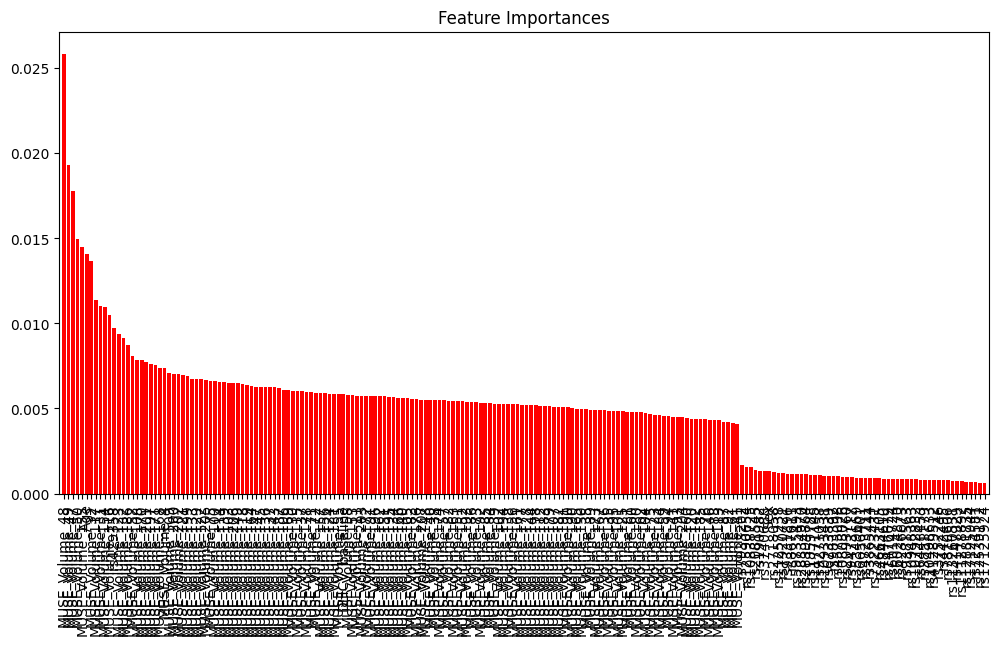

Outer Fold Metrics: {'Accuracy': 0.5128205128205128, 'Balanced Accuracy': 0.48041477572941327, 'Precision': 0.5084850615153645, 'Recall': 0.5128205128205128, 'F1 Score': 0.5099273535738151, 'AUC': 0.6599410775884712}
Outer Fold Metrics: {'Accuracy': 0.4829059829059829, 'Balanced Accuracy': 0.43623416075777305, 'Precision': 0.4733790552338939, 'Recall': 0.4829059829059829, 'F1 Score': 0.4755963361964506, 'AUC': 0.6409314218684438}
Outer Fold Metrics: {'Accuracy': 0.5085470085470085, 'Balanced Accuracy': 0.4769588540774982, 'Precision': 0.5088385809697284, 'Recall': 0.5085470085470085, 'F1 Score': 0.5038057277959358, 'AUC': 0.6523626883847358}
Outer Fold Metrics: {'Accuracy': 0.49145299145299143, 'Balanced Accuracy': 0.4612794612794613, 'Precision': 0.4917053680041417, 'Recall': 0.49145299145299143, 'F1 Score': 0.48371605981768206, 'AUC': 0.662335835714205}
Outer Fold Metrics: {'Accuracy': 0.5598290598290598, 'Balanced Accuracy': 0.4888004337156879, 'Precision': 0.5662469783927274, 'Reca

In [34]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


X = data_age_filtered.drop(['diagnosis', 'PTID'], axis=1)
y = data_age_filtered['diagnosis']

# Assuming X, y, roi_features are defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Visualize the feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()



# # 1 Top N features
# # Necessary columns for other parts of the pipeline
# necessary_columns = ['Sex', 'Age', 'DLICV_baseline']

# # Assuming you want to keep the top N features
# N = 10  # for example, the top 10 features
# top_N_features = X_train.columns[indices[:N]]

# # Combine the top N features with the necessary columns
# combined_features = list(set(top_N_features) | set(necessary_columns))

# # Keep only the combined features in your datasets
# X_train = X_train[combined_features]
# X_test = X_test[combined_features]

# roi_features = [feature for feature in roi_features if feature in X_train.columns]



# 2 Threshold Importance
# Define a threshold for feature importance
threshold = 0.01  # for example, a threshold of 0.01

# Get the features that meet the threshold
important_features = X_train.columns[importances > threshold]

# Necessary columns for other parts of the pipeline
necessary_columns = ['Sex', 'Age', 'DLICV_baseline']

# Combine the important features with the necessary columns
combined_features = list(set(important_features) | set(necessary_columns))

# Keep only the combined features in your datasets
X_train = X_train[combined_features]
X_test = X_test[combined_features]

# Update roi_features to include only those features present in the DataFrame
roi_features = [feature for feature in roi_features if feature in X_train.columns]

param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 30],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

outer_fold_results = []

for train_index, test_index in outer_cv.split(X_train, y_train):
    X_train_outer, X_val_outer = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_outer, y_val_outer = y_train.iloc[train_index], y_train.iloc[test_index]

    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)

    for inner_train_index, inner_val_index in inner_cv.split(X_train_outer, y_train_outer):
        X_train_inner, X_val_inner = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_val_index]
        y_train_inner, y_val_inner = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_val_index]

        # Preprocess for the inner fold
        data_controls_train_inner = X_train_inner[y_train_inner == 0]
        for roi_feature in roi_features:
            if roi_feature in X_train_inner.columns:
                regr = LinearRegression()
                regr.fit(data_controls_train_inner[['Sex', 'Age', 'DLICV_baseline']], data_controls_train_inner[roi_feature])
                # Apply correction to the training set
                correction_train = regr.predict(X_train_inner[['Sex', 'Age', 'DLICV_baseline']])
                X_train_inner[roi_feature] -= correction_train

                # Apply the same correction to the validation set
                correction_val = regr.predict(X_val_inner[['Sex', 'Age', 'DLICV_baseline']])
                X_val_inner[roi_feature] -= correction_val

        # Z-normalization for training and validation sets
        scaler = StandardScaler().fit(data_controls_train_inner[roi_features])
        X_train_inner[roi_features] = scaler.transform(X_train_inner[roi_features])
        X_val_inner[roi_features] = scaler.transform(X_val_inner[roi_features])

        X_train_inner = X_train_inner.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)
        X_val_inner = X_val_inner.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)

        grid_search.fit(X_train_inner, y_train_inner)

    # Evaluate the best model on the outer validation set
    best_model = grid_search.best_estimator_

    # We apply the linear correction and the z normalisation of the outer
    # loop after we are doe with the inner loop, in order to avoid applying
    # these filter twice.
    data_controls_train_outer = X_train_outer[y_train_outer == 0]
    for roi_feature in roi_features:
        if roi_feature in X_train_outer.columns:
            regr = LinearRegression()
            regr.fit(data_controls_train_outer[['Sex', 'Age', 'DLICV_baseline']], data_controls_train_outer[roi_feature])
            # Apply correction to the training set
            correction_train = regr.predict(X_train_outer[['Sex', 'Age', 'DLICV_baseline']])
            X_train_outer[roi_feature] -= correction_train

            # Apply the same correction to the validation set
            correction_val = regr.predict(X_val_outer[['Sex', 'Age', 'DLICV_baseline']])
            X_val_outer[roi_feature] -= correction_val

    # Z-normalization for training and validation sets
    scaler = StandardScaler().fit(data_controls_train_outer[roi_features])
    X_train_outer[roi_features] = scaler.transform(X_train_outer[roi_features])
    X_val_outer[roi_features] = scaler.transform(X_val_outer[roi_features])

    X_train_outer = X_train_outer.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)
    X_val_outer = X_val_outer.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)


    y_pred_val = best_model.predict(X_val_outer)

    # # Calculate and print metrics for each outer fold
    # accuracy = best_model.score(X_val_outer, y_val_outer)
    # print(f"Outer Fold Metrics: Accuracy: {accuracy}, Balanced Accuracy: {balanced_accuracy_score(y_val_outer, y_pred_val)}, ...")

    # Append metrics to dict
    fold_metrics = {
        "Accuracy": best_model.score(X_val_outer, y_val_outer),
        "Balanced Accuracy": balanced_accuracy_score(y_val_outer, y_pred_val),
        "Precision": precision_score(y_val_outer, y_pred_val, average='weighted'),
        "Recall": recall_score(y_val_outer, y_pred_val, average='weighted'),
        "F1 Score": f1_score(y_val_outer, y_pred_val, average='weighted'),
        "AUC": roc_auc_score(y_val_outer, best_model.predict_proba(X_val_outer), multi_class='ovr', average='weighted')
    }
    outer_fold_results.append(fold_metrics)
    print(f"Outer Fold Metrics: {fold_metrics}")

# Average metrics across all outer folds
avg_metrics = {metric: np.mean([fold[metric] for fold in outer_fold_results]) for metric in outer_fold_results[0]}
print("\nAverage Metrics Across All Outer Folds:")
print(avg_metrics)



In [35]:
# Retrieve the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Retrain the model on the entire training dataset (X_train, y_train) with these parameters
final_knn_model = KNeighborsClassifier(**best_params)

# Apply preprocessing (linear correction and Z-normalization) to the entire training dataset X_train
data_controls = X_train[y_train == 0]  # Control group for the training dataset
for roi_feature in roi_features:
    if roi_feature in X_train.columns:
        regr = LinearRegression()
        regr.fit(data_controls[['Sex', 'Age', 'DLICV_baseline']], data_controls[roi_feature])
        # Apply correction to the training set
        correction_train = regr.predict(X_train[['Sex', 'Age', 'DLICV_baseline']])
        X_train[roi_feature] -= correction_train

        # Apply the same correction to the test set
        correction_test = regr.predict(X_test[['Sex', 'Age', 'DLICV_baseline']])
        X_test[roi_feature] -= correction_test


# Z-normalization
scaler = StandardScaler().fit(data_controls[roi_features])
X_train[roi_features] = scaler.transform(X_train[roi_features])
X_test[roi_features] = scaler.transform(X_test[roi_features])


X_train = X_train.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)
X_test = X_test.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)

# Train the final model on the entire training dataset
final_knn_model.fit(X_train, y_train)

# # Apply linear correction and Z-normalization to X_test
# for roi_feature in roi_features:
#     if roi_feature in X_test.columns:
#         correction_test = regr.predict(X_test[['Sex', 'Age', 'DLICV_baseline']])
#         X_test[roi_feature] -= correction_test
# X_test[roi_features] = scaler.transform(X_test[roi_features])
# X_test = X_test.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)

# Evaluate the final model on the test set (X_test, y_test)
y_pred_test = final_knn_model.predict(X_test)
test_accuracy = final_knn_model.score(X_test, y_test)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
test_auc = roc_auc_score(y_test, final_knn_model.predict_proba(X_test), multi_class='ovr', average='weighted')

print(f"Test set Metrics: Accuracy: {test_accuracy}, Balanced Accuracy: {test_balanced_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}, AUC: {test_auc}")

Test set Metrics: Accuracy: 0.5836177474402731, Balanced Accuracy: 0.5226362726362727, Precision: 0.5986025001514631, Recall: 0.5836177474402732, F1 Score: 0.5692471218483718, AUC: 0.7332305618493131


In [36]:
best_params

{'metric': 'euclidean', 'n_neighbors': 30, 'weights': 'distance'}

#### Nested CV with Randomized Search

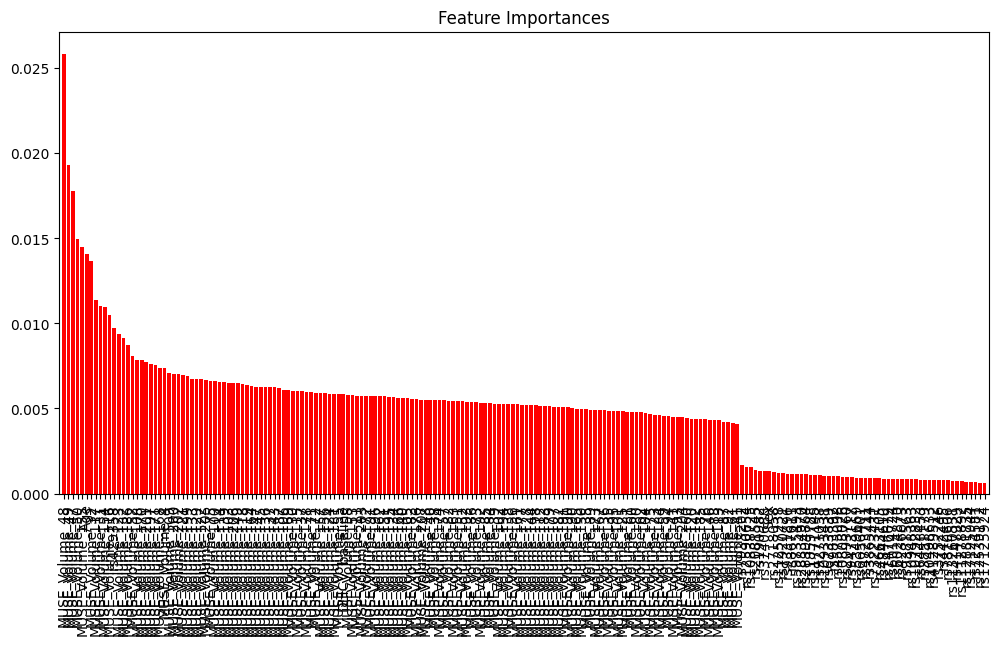

Outer Fold Metrics: Accuracy: 0.5982905982905983, Balanced Accuracy: 0.5336252071888187, ...
Outer Fold Metrics: {'Accuracy': 0.5982905982905983, 'Balanced Accuracy': 0.5336252071888187, 'Precision': 0.6064327713263884, 'Recall': 0.5982905982905983, 'F1 Score': 0.5783174339927669, 'AUC': 0.761343587159068}
Outer Fold Metrics: Accuracy: 0.594017094017094, Balanced Accuracy: 0.5308813666311595, ...
Outer Fold Metrics: {'Accuracy': 0.594017094017094, 'Balanced Accuracy': 0.5308813666311595, 'Precision': 0.5892962673984571, 'Recall': 0.594017094017094, 'F1 Score': 0.5791635986948487, 'AUC': 0.7513749235513635}
Outer Fold Metrics: Accuracy: 0.6239316239316239, Balanced Accuracy: 0.5626248359299207, ...
Outer Fold Metrics: {'Accuracy': 0.6239316239316239, 'Balanced Accuracy': 0.5626248359299207, 'Precision': 0.648102224440424, 'Recall': 0.6239316239316239, 'F1 Score': 0.6107926931456342, 'AUC': 0.7732211685680128}
Outer Fold Metrics: Accuracy: 0.6153846153846154, Balanced Accuracy: 0.5307524

In [37]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

X = data_age_filtered.drop(['diagnosis', 'PTID'], axis=1)
y = data_age_filtered['diagnosis']

# Assuming X, y, roi_features are defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)







# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Visualize the feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()



# # 1 Top N features
# # Necessary columns for other parts of the pipeline
# necessary_columns = ['Sex', 'Age', 'DLICV_baseline']

# # Assuming you want to keep the top N features
# N = 10  # for example, the top 10 features
# top_N_features = X_train.columns[indices[:N]]

# # Combine the top N features with the necessary columns
# combined_features = list(set(top_N_features) | set(necessary_columns))

# # Keep only the combined features in your datasets
# X_train = X_train[combined_features]
# X_test = X_test[combined_features]

# roi_features = [feature for feature in roi_features if feature in X_train.columns]



# 2 Threshold Importance
# Define a threshold for feature importance
threshold = 0.01  # for example, a threshold of 0.01

# Get the features that meet the threshold
important_features = X_train.columns[importances > threshold]

# Necessary columns for other parts of the pipeline
necessary_columns = ['Sex', 'Age', 'DLICV_baseline']

# Combine the important features with the necessary columns
combined_features = list(set(important_features) | set(necessary_columns))

# Keep only the combined features in your datasets
X_train = X_train[combined_features]
X_test = X_test[combined_features]

# Update roi_features to include only those features present in the DataFrame
roi_features = [feature for feature in roi_features if feature in X_train.columns]












# Define parameter distribution (instead of a fixed grid)
param_dist = {
    'n_neighbors': stats.randint(3, 1000),  # Uniformly distributed integers from 3 to 30
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

outer_fold_results = []

for train_index, test_index in outer_cv.split(X_train, y_train):
    X_train_outer, X_val_outer = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_outer, y_val_outer = y_train.iloc[train_index], y_train.iloc[test_index]

    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Use RandomizedSearchCV
    n_iter_search = 20  # Number of parameter settings sampled
    random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist, n_iter=n_iter_search, cv=inner_cv, scoring='accuracy', n_jobs=-1, random_state=42)

    for inner_train_index, inner_val_index in inner_cv.split(X_train_outer, y_train_outer):
        X_train_inner, X_val_inner = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_val_index]
        y_train_inner, y_val_inner = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_val_index]

        # Preprocess for the inner fold
        data_controls_train_inner = X_train_inner[y_train_inner == 0]
        for roi_feature in roi_features:
            if roi_feature in X_train_inner.columns:
                regr = LinearRegression()
                regr.fit(data_controls_train_inner[['Sex', 'Age', 'DLICV_baseline']], data_controls_train_inner[roi_feature])
                # Apply correction to the training set
                correction_train = regr.predict(X_train_inner[['Sex', 'Age', 'DLICV_baseline']])
                X_train_inner[roi_feature] -= correction_train

                # Apply the same correction to the validation set
                correction_val = regr.predict(X_val_inner[['Sex', 'Age', 'DLICV_baseline']])
                X_val_inner[roi_feature] -= correction_val

        # Z-normalization for training and validation sets
        scaler = StandardScaler().fit(data_controls_train_inner[roi_features])
        X_train_inner[roi_features] = scaler.transform(X_train_inner[roi_features])
        X_val_inner[roi_features] = scaler.transform(X_val_inner[roi_features])

        X_train_inner = X_train_inner.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)
        X_val_inner = X_val_inner.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)

        random_search.fit(X_train_inner, y_train_inner)

    # Evaluate the best model on the outer validation set
    best_model = grid_search.best_estimator_

    # We apply the linear correction and the z normalisation of the outer
    # loop after we are doe with the inner loop, in order to avoid applying
    # these filter twice.
    data_controls_train_outer = X_train_outer[y_train_outer == 0]
    for roi_feature in roi_features:
        if roi_feature in X_train_outer.columns:
            regr = LinearRegression()
            regr.fit(data_controls_train_outer[['Sex', 'Age', 'DLICV_baseline']], data_controls_train_outer[roi_feature])
            # Apply correction to the training set
            correction_train = regr.predict(X_train_outer[['Sex', 'Age', 'DLICV_baseline']])
            X_train_outer[roi_feature] -= correction_train

            # Apply the same correction to the validation set
            correction_val = regr.predict(X_val_outer[['Sex', 'Age', 'DLICV_baseline']])
            X_val_outer[roi_feature] -= correction_val

    # Z-normalization for training and validation sets
    scaler = StandardScaler().fit(data_controls_train_outer[roi_features])
    X_train_outer[roi_features] = scaler.transform(X_train_outer[roi_features])
    X_val_outer[roi_features] = scaler.transform(X_val_outer[roi_features])

    X_train_outer = X_train_outer.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)
    X_val_outer = X_val_outer.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)


    y_pred_val = best_model.predict(X_val_outer)
    # Calculate and print metrics for each outer fold
    accuracy = best_model.score(X_val_outer, y_val_outer)
    print(f"Outer Fold Metrics: Accuracy: {accuracy}, Balanced Accuracy: {balanced_accuracy_score(y_val_outer, y_pred_val)}, ...")

    # Append metrics to dict
    fold_metrics = {
        "Accuracy": best_model.score(X_val_outer, y_val_outer),
        "Balanced Accuracy": balanced_accuracy_score(y_val_outer, y_pred_val),
        "Precision": precision_score(y_val_outer, y_pred_val, average='weighted'),
        "Recall": recall_score(y_val_outer, y_pred_val, average='weighted'),
        "F1 Score": f1_score(y_val_outer, y_pred_val, average='weighted'),
        "AUC": roc_auc_score(y_val_outer, best_model.predict_proba(X_val_outer), multi_class='ovr', average='weighted')
    }
    outer_fold_results.append(fold_metrics)
    print(f"Outer Fold Metrics: {fold_metrics}")

# Average metrics across all outer folds
avg_metrics = {metric: np.mean([fold[metric] for fold in outer_fold_results]) for metric in outer_fold_results[0]}
print("\nAverage Metrics Across All Outer Folds:")
print(avg_metrics)



In [38]:
# Retrieve the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Retrain the model on the entire training dataset (X_train, y_train) with these parameters
final_knn_model = KNeighborsClassifier(**best_params)

# Apply preprocessing (linear correction and Z-normalization) to the entire training dataset X_train
data_controls = X_train[y_train == 0]  # Control group for the training dataset
for roi_feature in roi_features:
    if roi_feature in X_train.columns:
        regr = LinearRegression()
        regr.fit(data_controls[['Sex', 'Age', 'DLICV_baseline']], data_controls[roi_feature])
        # Apply correction to the training set
        correction_train = regr.predict(X_train[['Sex', 'Age', 'DLICV_baseline']])
        X_train[roi_feature] -= correction_train

        # Apply the same correction to the test set
        correction_test = regr.predict(X_test[['Sex', 'Age', 'DLICV_baseline']])
        X_test[roi_feature] -= correction_test


# Z-normalization
scaler = StandardScaler().fit(data_controls[roi_features])
X_train[roi_features] = scaler.transform(X_train[roi_features])
X_test[roi_features] = scaler.transform(X_test[roi_features])


X_train = X_train.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)
X_test = X_test.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)

# Train the final model on the entire training dataset
final_knn_model.fit(X_train, y_train)

# # Apply linear correction and Z-normalization to X_test
# for roi_feature in roi_features:
#     if roi_feature in X_test.columns:
#         correction_test = regr.predict(X_test[['Sex', 'Age', 'DLICV_baseline']])
#         X_test[roi_feature] -= correction_test
# X_test[roi_features] = scaler.transform(X_test[roi_features])
# X_test = X_test.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)

# Evaluate the final model on the test set (X_test, y_test)
y_pred_test = final_knn_model.predict(X_test)
test_accuracy = final_knn_model.score(X_test, y_test)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
test_auc = roc_auc_score(y_test, final_knn_model.predict_proba(X_test), multi_class='ovr', average='weighted')

print(f"Test set Metrics: Accuracy: {test_accuracy}, Balanced Accuracy: {test_balanced_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}, AUC: {test_auc}")

Test set Metrics: Accuracy: 0.5836177474402731, Balanced Accuracy: 0.5226362726362727, Precision: 0.5986025001514631, Recall: 0.5836177474402732, F1 Score: 0.5692471218483718, AUC: 0.7332305618493131


In [39]:
best_params

{'metric': 'euclidean', 'n_neighbors': 30, 'weights': 'distance'}

##### back ups


In [40]:
# only corrected and standardized outer folds
# (which include the inner folds, but it is the same problem of data
# leakage even though the whole data are train data. Even though all of these
# data are train data, we should treat them as validation/test data for validating
# and evaluating the model.)

# from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
# from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
# from sklearn.linear_model import LinearRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.preprocessing import StandardScaler

# # Splitting dataset into train and test
# X = data_age_filtered.drop(['diagnosis', 'PTID'], axis=1)
# y = data_age_filtered['diagnosis']

# # Assuming X, y, roi_features are defined
# # Split the dataset into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Define parameter grid for KNN
# param_grid = {
#     'n_neighbors': [3, 5, 7, 10, 15, 30],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan']
# }

# # Define outer cross-validation
# outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Lists to store metrics for each outer fold
# outer_fold_accuracy = []
# outer_fold_balanced_accuracy = []
# outer_fold_precision = []
# outer_fold_recall = []
# outer_fold_f1 = []
# outer_fold_auc = []

# # Outer loop for model evaluation
# for train_index, test_index in outer_cv.split(X_train, y_train):
#     # Split training data into training and validation for the current outer fold
#     X_train_outer, X_val_outer = X_train.iloc[train_index], X_train.iloc[test_index]
#     y_train_outer, y_val_outer = y_train.iloc[train_index], y_train.iloc[test_index]

#     # Apply preprocessing (linear correction and Z-normalization) to X_train_outer and X_val_outer
#     # Linear correction
#     data_controls_train_outer = X_train_outer[y_train_outer == 0]  # Control group for the fold
#     for roi_feature in roi_features:
#         if roi_feature in X_train_outer.columns:
#             regr = LinearRegression()
#             regr.fit(data_controls_train_outer[['Sex', 'Age', 'DLICV_baseline']], data_controls_train_outer[roi_feature])
#             # Apply correction to the training set
#             correction_train = regr.predict(X_train_outer[['Sex', 'Age', 'DLICV_baseline']])
#             X_train_outer[roi_feature] -= correction_train

#             # Apply the same correction to the validation set
#             correction_val = regr.predict(X_val_outer[['Sex', 'Age', 'DLICV_baseline']])
#             X_val_outer[roi_feature] -= correction_val

#     # Z-normalization for training and validation sets
#     scaler = StandardScaler().fit(data_controls_train_outer[roi_features])
#     X_train_outer[roi_features] = scaler.transform(X_train_outer[roi_features])
#     X_val_outer[roi_features] = scaler.transform(X_val_outer[roi_features])

#     X_train_outer = X_train_outer.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)
#     X_val_outer = X_val_outer.drop(['Sex', 'Age', 'DLICV_baseline'], axis=1)

#     # Inner loop for hyperparameter tuning
#     inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#     grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
#     grid_search.fit(X_train_outer, y_train_outer)

#     # Train model with best parameters on the entire training set of the outer fold
#     best_model = grid_search.best_estimator_
#     best_model.fit(X_train_outer, y_train_outer)

#     # Evaluate model on the validation set of the outer fold
#     y_pred_val = best_model.predict(X_val_outer)
#     outer_fold_accuracy.append(best_model.score(X_val_outer, y_val_outer))
#     outer_fold_balanced_accuracy.append(balanced_accuracy_score(y_val_outer, y_pred_val))
#     outer_fold_precision.append(precision_score(y_val_outer, y_pred_val, average='weighted'))
#     outer_fold_recall.append(recall_score(y_val_outer, y_pred_val, average='weighted'))
#     outer_fold_f1.append(f1_score(y_val_outer, y_pred_val, average='weighted'))
#     outer_fold_auc.append(roc_auc_score(y_val_outer, best_model.predict_proba(X_val_outer), multi_class='ovr', average='weighted'))

#     # Evaluate model on the validation set of the outer fold
#     y_pred_val = best_model.predict(X_val_outer)
#     accuracy = best_model.score(X_val_outer, y_val_outer)
#     balanced_accuracy = balanced_accuracy_score(y_val_outer, y_pred_val)
#     precision = precision_score(y_val_outer, y_pred_val, average='weighted')
#     recall = recall_score(y_val_outer, y_pred_val, average='weighted')
#     f1 = f1_score(y_val_outer, y_pred_val, average='weighted')
#     auc = roc_auc_score(y_val_outer, best_model.predict_proba(X_val_outer), multi_class='ovr', average='weighted')

#     # Append metrics to lists
#     outer_fold_accuracy.append(accuracy)
#     outer_fold_balanced_accuracy.append(balanced_accuracy)
#     outer_fold_precision.append(precision)
#     outer_fold_recall.append(recall)
#     outer_fold_f1.append(f1)
#     outer_fold_auc.append(auc)


# # Calculate average metrics across all outer folds
# print("Average Metrics Across All Outer Folds:")
# print(f"Accuracy: {np.mean(outer_fold_accuracy)}")
# print(f"Balanced Accuracy: {np.mean(outer_fold_balanced_accuracy)}")
# print(f"Precision: {np.mean(outer_fold_precision)}")
# print(f"Recall: {np.mean(outer_fold_recall)}")
# print(f"F1 Score: {np.mean(outer_fold_f1)}")
# print(f"AUC: {np.mean(outer_fold_auc)}")
